## 22BAI1118 Mayank Raj

##### Register Numbers - Ending with EVEN number
##### Variational Auto-Encoder


## Import Libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load and Preprocess Data

In [10]:
def load_and_preprocess_data():
    (x_train, _), (x_test, _) = fashion_mnist.load_data()
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)).astype('float32') / 255.0
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)).astype('float32') / 255.0
    return x_train, x_test

x_train, x_test = load_and_preprocess_data()

## Visualization

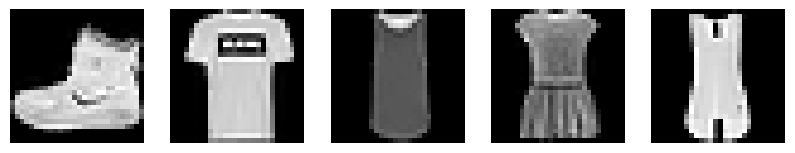

In [29]:
def display_sample_images(x_train, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

display_sample_images(x_train, 5)

## Define Latent Space as a Distribution

In [11]:
def create_encoder(latent_dim):
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    return models.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

latent_dim = 64  
encoder = create_encoder(latent_dim)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │        320 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 14, 14,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 7, 7, 64)  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 3136)      │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    401,536 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │      8,256 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │      8,256 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,864 (1.67 MB)

 Trainable params: 436,864 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

## Define Reparameterization

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def create_variational_encoder(latent_dim):
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    z_mean, z_log_var = create_encoder(latent_dim)(encoder_inputs)
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return models.Model(encoder_inputs, [z_mean, z_log_var, z], name='variational_encoder')

variational_encoder = create_variational_encoder(latent_dim)
variational_encoder.summary()


Model: "variational_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 64),      │    436,864 │ input_layer_9[0]… │
│ (Functional)        │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ encoder[0][0],    │
│                     │                   │            │ encoder[0][1]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,864 (1.67 MB)

 Trainable params: 436,864 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

## Define the Decoder

In [13]:
def create_decoder(latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    return models.Model(decoder_inputs, decoder_outputs, name='decoder')

decoder = create_decoder(latent_dim)
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3136)           │       203,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 7, 7, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 14, 14, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,521 (1013.75 KB)

 Trainable params: 259,521 (1013.75 KB)

 Non-trainable params: 0 (0.00 B)

## Create the VAE Class

In [14]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)  
        return reconstructed

vae = VAE(variational_encoder, decoder)
vae.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy)

## Data Augmentation and Callbacks

In [23]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

callbacks = [
    ModelCheckpoint('vae_model.keras', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=20)
]

## Train the VAE

In [25]:
vae.fit(data_gen.flow(x_train, x_train, batch_size=64), 
        epochs=50, 
        validation_data=(x_test, x_test), 
        callbacks=callbacks)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.4009 - val_loss: 0.4071
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.4012 - val_loss: 0.4092
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.4002 - val_loss: 0.4061
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.4004 - val_loss: 0.4047
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.3996 - val_loss: 0.4103
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.3996 - val_loss: 0.4068
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.3994 - val_loss: 0.4073
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.3996 - val_loss: 0.4070
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.3988 - val_loss: 0.4067
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.3986 - val_loss: 0.4111
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.3993 - val_loss: 0.4115
Epoch 12/50
938/938 ━━━━━━━━━━

## Inference 
##### The VAE model shows stable and consistent learning over 50 epochs, with both training and validation losses decreasing gradually and staying closely aligned, indicating good generalization without overfitting. The marginal reduction in loss over the last several epochs suggests that the model is nearing convergence. 

##### Overall, the model is performing well and has learned to reconstruct the data effectively.






## Generating New Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


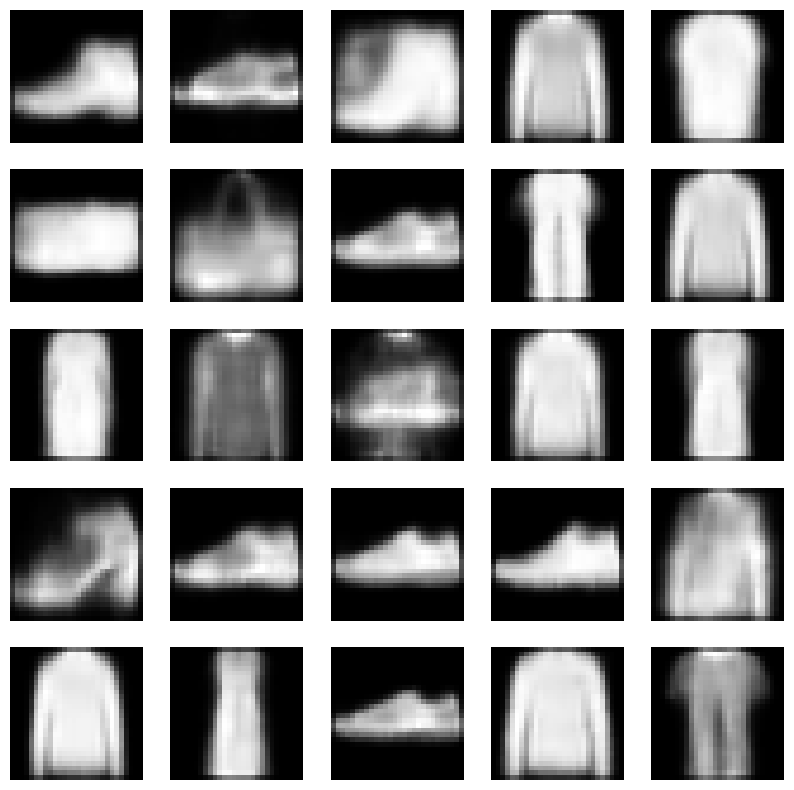

In [28]:
def plot_generated_images(decoder, n=25):
    z_samples = tf.random.normal(shape=(n, latent_dim))  
    generated_images = decoder.predict(z_samples)

    plt.figure(figsize=(10, 10)) 
    for i in range(n):
        plt.subplot(5, 5, i + 1)  
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

plot_generated_images(decoder)


## Conclusion 
##### The Variational Autoencoder (VAE) model showed stable training behavior over 50 epochs, with the training and validation losses remaining close to each other, indicating no significant overfitting. The final validation loss of approximately 0.4006 suggests that the model has learned to reconstruct the input data.